In [1]:
# this file is for  base line model training

In [2]:
#import useful package
from __future__ import print_function
import os
import argparse
import shutil

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from torchvision import datasets, transforms

import models
from torchinfo import summary
from collections import OrderedDict
from matplotlib import pyplot as plt

In [3]:
# set up device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

cuda


In [4]:
# downlaoding data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# load baseline mode
print('==> Building model..')

model = models.resnet()
params = sum(p.numel() for p in model.parameters())
print(params)
# print the overall architecture
summary(model, input_size=(1,3, 32, 32))

==> Building model..
11105866


Layer (type:depth-idx)                   Output Shape              Param #
resnet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─FusionBlock: 2-1                  [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 64, 32, 32]           4,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 64, 32, 32]           4,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│    └─FusionBlock: 2-2                  [1, 64, 32, 32]           --
│    │    └─Sequential: 3-7              [1, 64, 32, 32]           4,928
│    │    └─BatchNorm2d: 3-8             [1, 64, 32, 32]           128


In [6]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9, weight_decay=5e-4)

In [7]:
# additional subgradient descent on the sparsity-induced penalty term

# trade-off factors 
s  = 0.00001

# add new item on grad computation
def updateBN():
    for name,m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d) and 'fusion' not in name:
            m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1 regularization

#training function
def train(epoch,train_loss_list,train_acc_list):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss +=loss.item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        loss.backward()
        
        # calculate the gradient for BN scaling factors
        updateBN()
        
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))
                  
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc = correct / len(train_loader.dataset)
    train_acc_list.append(train_acc)
    
    print('\nTraining Set: Average loss: {:.4f},Accuracy: {}/{} ({:.1f}%)\n'.format(
            train_loss, correct, len(train_loader.dataset),100.*train_acc))

# test function
def test(test_loss_list,test_acc_list):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item() # sum up batch loss

            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        test_loss_list.append(test_loss)
        test_acc = correct / float(len(test_loader.dataset))
        test_acc_list.append(test_acc)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * test_acc))
        
        return test_acc

def save_checkpoint(state, is_best, filepath):
    torch.save(state, os.path.join(filepath, 'baseline.pth.tar'))
    if is_best:
        print('\n!!!!!!!!!!!!!!!!! NEW BEST ACC !!!!!!!!!!!!! \n')
        shutil.copyfile(os.path.join(filepath, 'baseline.pth.tar'), os.path.join(filepath, 'baseline_model_best.pth.tar'))



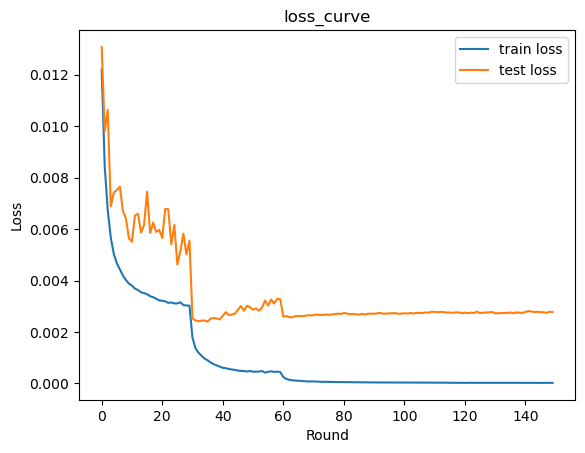

In [11]:
plt.figure()
ax=plt.axes()
plt.xlabel('Round')    # x轴标签
plt.ylabel('Loss')     # y轴标签

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(test_loss)), test_loss, label="test loss")
plt.legend(loc='upper right')
plt.title("loss_curve")
plt.savefig("./checkpoint/baseline/baseline_loss_curve.png")

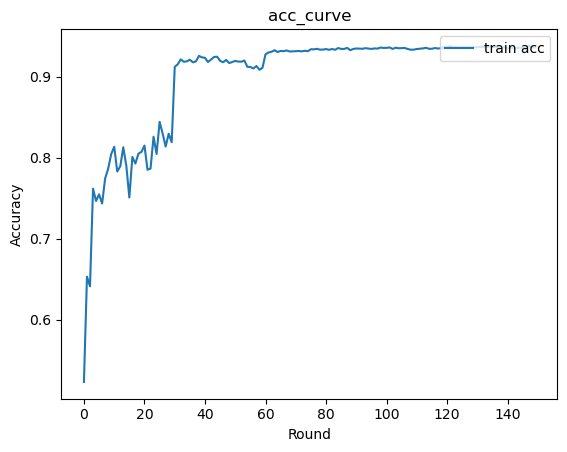

In [13]:
plt.figure()
ax=plt.axes()
plt.xlabel('Round')    # x轴标签
plt.ylabel('Accuracy')     # y轴标签

plt.plot(range(len(test_acc)), test_acc, label="train acc")
plt.legend(loc='upper right')
plt.title("acc_curve")
plt.savefig("./checkpoint/baseline/baseline_acc_curve.png")

In [8]:
best_prec1 = 0.

import time

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

train_loss = []
train_acc = []
test_loss = []
test_acc = []

# training 
for epoch in range(0, 150):
    if epoch in [30, 60]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        
    start_time = time.time()
    
    train(epoch,train_loss,train_acc)
    prec1 = test(test_loss,test_acc)
    
    end_time = time.time()
    
    interval = end_time - start_time
    print('One epoch time cost: {:.3f} s \n'.format(interval))
   
    
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best, filepath='./checkpoint/baseline')
    
    print('----------------------------------------------- \n')

    
print("Best accuracy: "+str(best_prec1))

# write loss data to txt file
savepath = os.path.join('./checkpoint/baseline', "baseline_train_loss.txt")
with open(savepath, "w") as fp:
    for data in train_loss:
        fp.write(str(data)+"\n")
    
savepath = os.path.join('./checkpoint/baseline', "baseline_train_acc.txt")
with open(savepath, "w") as fp:
       for data in train_acc:
        fp.write(str(data)+"\n")
    
savepath = os.path.join('./checkpoint/baseline', "baseline_test_loss.txt")
with open(savepath, "w") as fp:
    for data in test_loss:
        fp.write(str(data)+"\n")
    
savepath = os.path.join('./checkpoint/baseline', "baseline_test_acc.txt")
with open(savepath, "w") as fp:
    for data in test_acc:
        fp.write(str(data)+"\n")

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.000021


KeyboardInterrupt: 